In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

import statsmodels.tsa.stattools as smt
import statsmodels.tsa.seasonal as sms
import statsmodels.tsa.api as sma
import statsmodels.tsa.statespace as sme

from pandas.core import datetools
from sklearn.metrics import r2_score

%matplotlib inline

/usr/local/lib/python3.5/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Ввод данных

In [2]:
d_set = pd.read_csv('training.csv', index_col=['Date'], parse_dates=['Date'])
d_set.head(n=3)

,Value
Date,
1959-01-01,22.8331
1959-02-01,23.2802
1959-03-01,23.6156


### Проверка стационарности с помощью построения графиков

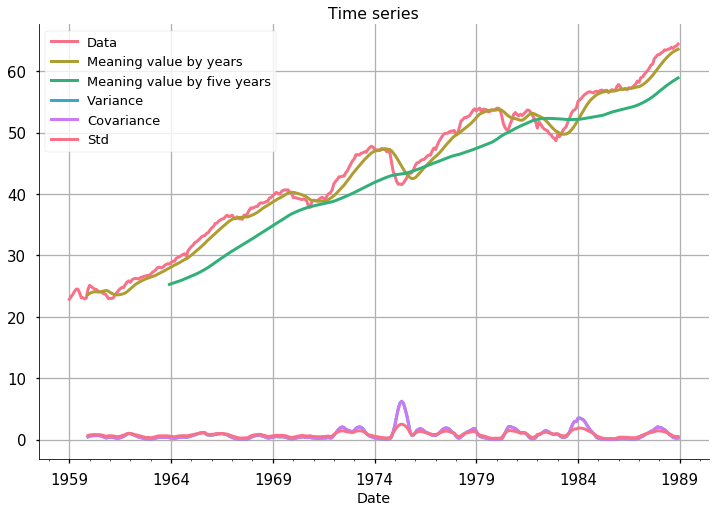

In [3]:
sb.set_context("talk", rc={"lines.linewidth": 3})
sb.set_palette("husl", 5)


def check_stationarity_graph(d_set):
    dma_set_y = d_set.rolling(12).mean()
    dma_set_fy = d_set.rolling(60).mean()
    dmv_set = d_set.rolling(12).var()
    dmcv_set = d_set.rolling(12).cov(d_set)
    dms_set = d_set.rolling(12).std()

    fig = d_set.plot(figsize=(12, 8), title='Time series', fontsize=15)
    dma_set_y.plot(ax=fig)
    dma_set_fy.plot(ax=fig)
    dmv_set.plot(ax=fig)
    dmcv_set.plot(ax=fig)
    dms_set.plot(ax=fig)
    fig.legend(['Data', 'Meaning value by years',
                'Meaning value by five years', 'Variance',
                'Covariance', 'Std'])
    fig.grid()
    sb.despine()


check_stationarity_graph(d_set)

### Проверка стационарности с помощью теста Дики-Фуллера

In [4]:
def check_stationarity_DF(dset):
    DF_test = smt.adfuller(dset.dropna())
    if DF_test[0] > DF_test[4]['5%']:
        str = 'Ряд не стационарен'          # Есть единичные корни
    else:
        str = 'Ряд стационарен'             # Единичных корней нет
    return str


print(check_stationarity_DF(d_set['Value']))

Ряд не стационарен


### Проверка достоверности статистики

In [9]:
DF_test = smt.adfuller(d_set['Value'].dropna())
print('p-value for statistic = ', DF_test[1])

p-value for statistic =  0.931851042299


### Разложение ряда в аддитивную модель Y[t] = T[t] + S[t] + e[t]

Тренд: Ряд не стационарен
Сезональность: Ряд стационарен
Остаток: Ряд стационарен


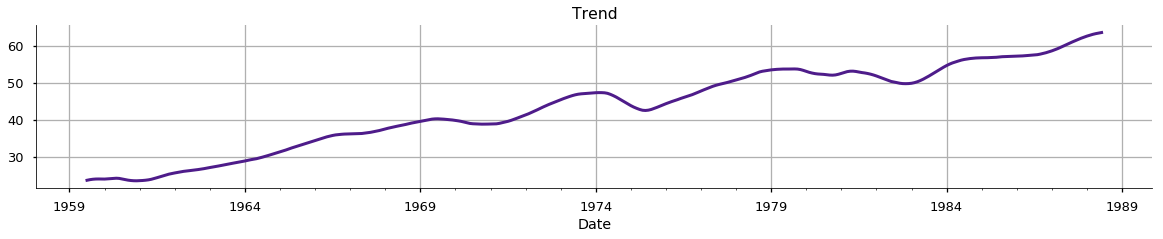

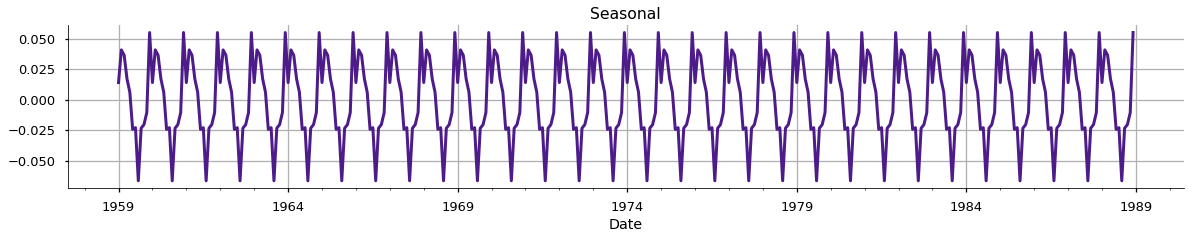

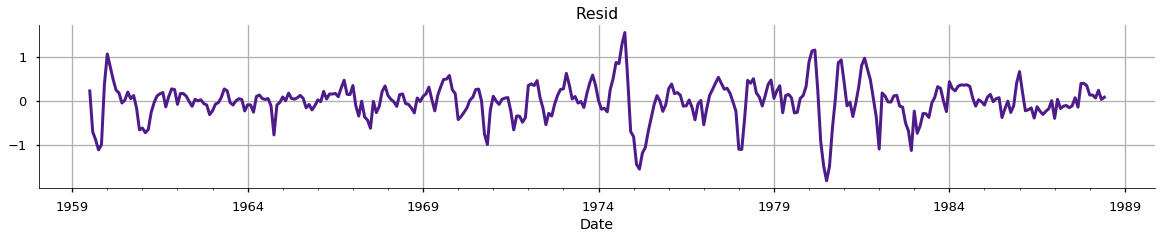

In [6]:
addit_m = sms.seasonal_decompose(d_set['Value'], model='additive')

sb.set_palette("Purples_r", 10)
fig_one = plt.figure()
addit_m.trend.plot(figsize=(20, 3), title='Trend')
plt.grid('on')
sb.despine()

fig_two = plt.figure()
addit_m.seasonal.plot(figsize=(20, 3), title='Seasonal')
plt.grid('on')
sb.despine()

fig_three = plt.figure()
addit_m.resid.plot(figsize=(20, 3), title='Resid')
plt.grid('on')
sb.despine()

print('Тренд: ' + check_stationarity_DF(addit_m.trend))
print('Сезональность: ' + check_stationarity_DF(addit_m.seasonal))
print('Остаток: ' + check_stationarity_DF(addit_m.resid))

### Разложение в мультипликативную модель Y[t] = T[t]  x  S[t]  x  e[t]

Тренд: Ряд не стационарен
Сезональность: Ряд стационарен
Остаток: Ряд стационарен


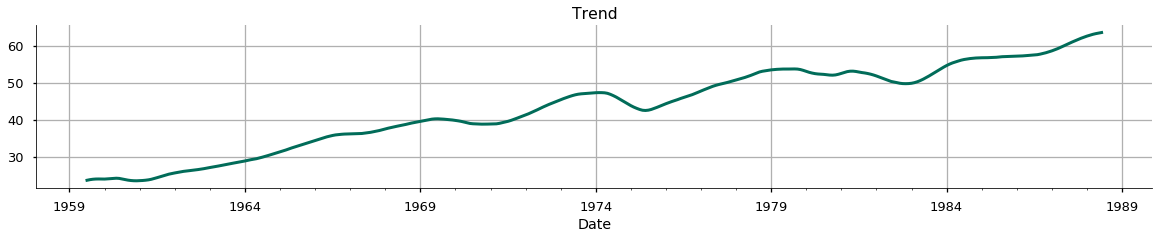

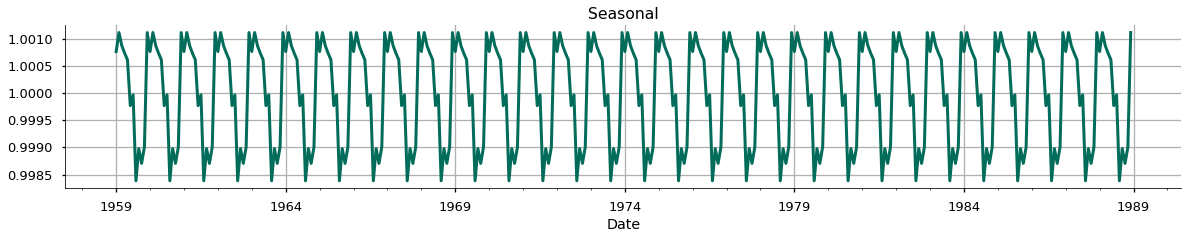

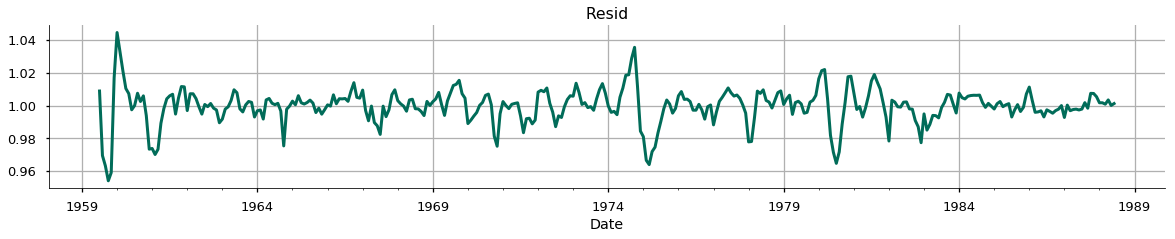

In [7]:
multi_m = sms.seasonal_decompose(d_set['Value'], model='multiplicative')

sb.set_palette("PuBuGn_r", 7)

fig_one = plt.figure()
multi_m.trend.plot(figsize=(20, 3), title='Trend')
plt.grid('on')
sb.despine()

fig_two = plt.figure()
multi_m.seasonal.plot(figsize=(20, 3), title='Seasonal')
plt.grid('on')
sb.despine()

fig_three = plt.figure()
multi_m.resid.plot(figsize=(20, 3), title='Resid')
plt.grid('on')
sb.despine()

sb.set_palette("Purples_r", 10)

print('Тренд: ' + check_stationarity_DF(multi_m.trend))
print('Сезональность: ' + check_stationarity_DF(multi_m.seasonal))
print('Остаток: ' + check_stationarity_DF(multi_m.resid))

#### Графики функции автокорреляции и функции частичной автокорреляции

In [8]:
def graphs(d_set):
    sb.set_palette("colorblind", 5)

    fig_one = d_set.plot(figsize=(20, 5), title='Time Series', fontsize=15)
    plt.grid('on')
    sb.despine()

    fig_two = plt.figure(figsize=(20, 5))
    layout = (1, 4)
    acf_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    pacf_ax = plt.subplot2grid(layout, (0, 2), colspan=2)

    sma.graphics.plot_acf(d_set, lags=50, ax=acf_ax, alpha=0.5)
    sb.despine()

    sma.graphics.plot_pacf(d_set, lags=50, ax=pacf_ax, alpha=0.5)
    sb.despine()

### Порядок интегрированности ряда

Ряд является интегрированным порядка k=1



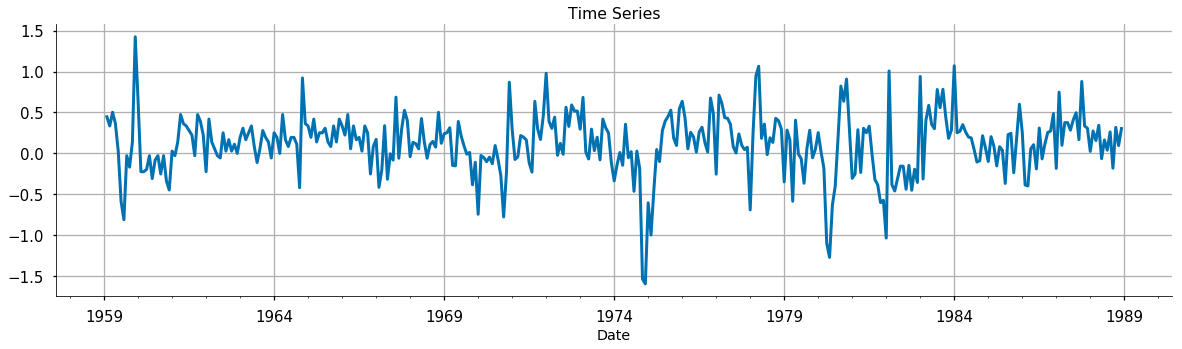

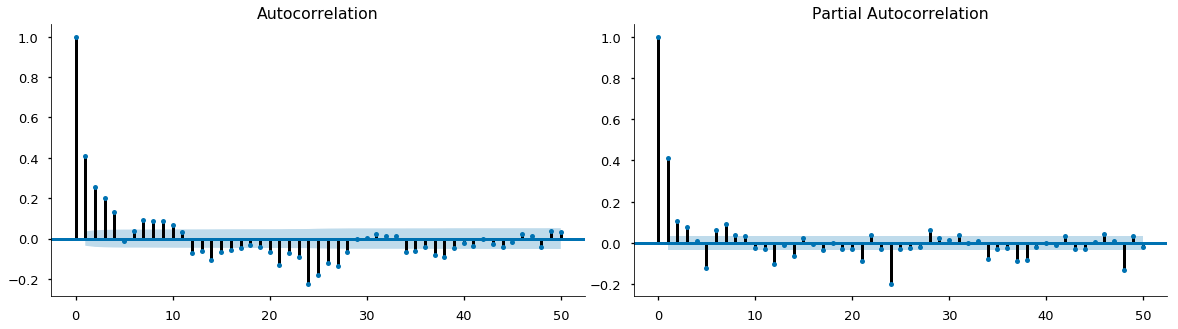

In [9]:
def int_k(dset, k):
    ans = False
    d_set_diff = dset['Value'].diff(periods=k).dropna()
    str_one = check_stationarity_DF(d_set_diff)
    if str_one == 'Ряд стационарен':
        str_two = 'Ряд является интегрированным порядка k=' + str(k) + '\n'
        ans = True
    else:
        str_two = 'Ряд не является интегрированным порядка k=' + str(k) + '\n'
    print(str_two)
    graphs(d_set_diff)
    return ans

if int_k(d_set, 1):
    d = 1

## Построение модели ARIMA

### Ввод данных для теста

In [10]:
d_set_test = pd.read_csv('testing.csv', index_col=['Date'],
                         parse_dates=['Date'])
d_set_test.head(n=3)

,Value
Date,
1989-01-01,64.6158
1989-02-01,64.3268
1989-03-01,64.4548


### Построение ARIMA(1,1,1)

In [11]:
p = 1
q = 1

model1 = sma.ARIMA(d_set, order=(p, d, q)).fit()
print(model1.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                  359
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -120.367
Method:                       css-mle   S.D. of innovations              0.338
Date:                Sun, 10 Dec 2017   AIC                            248.734
Time:                        20:06:40   BIC                            264.267
Sample:                    02-01-1959   HQIC                           254.911
                         - 12-01-1988                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1176      0.036      3.271      0.001       0.047       0.188
ar.L1.D.Value     0.6531      0.091      7.185      0.000       0.475       0.831
ma.L1.D.Value    -0.2984      0.115     

#### Построение предсказания

In [12]:
pred1 = model1.predict('1989-01-01', '1993-12-01', typ='levels')
pred1.head(n=3)

1989-01-01    64.606116
1989-02-01    64.767814
1989-03-01    64.914219
Freq: MS, dtype: float64

##### График предсказания

In [13]:
def pred_gr(d_set, pred):
    fig = d_set_test.plot(figsize=(16, 8), title='Time series', fontsize=15)
    sb.set_palette("nipy_spectral", 10)
    pred.plot(ax=fig)
    d_set.plot(ax=fig)
    fig.legend(['Test data', 'Prediction', 'Training data'])
    fig.grid()
    sb.despine()
    return fig

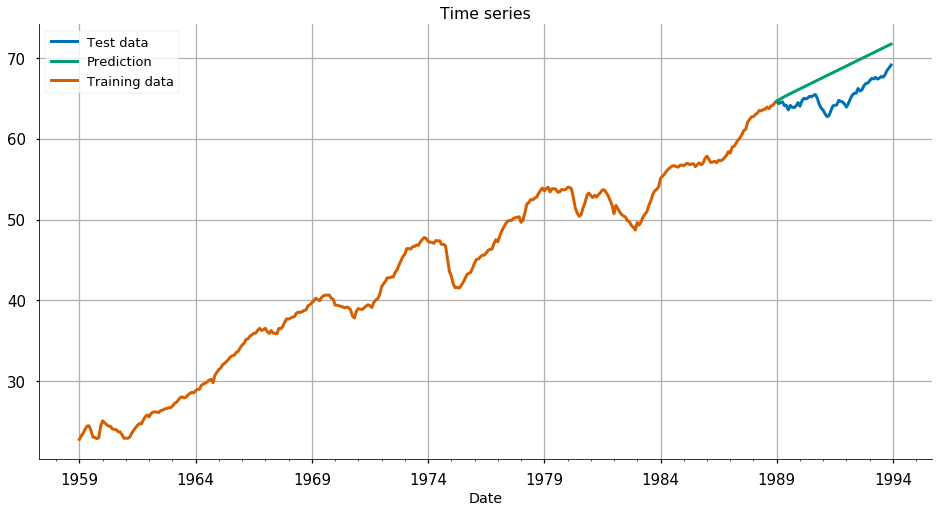

In [14]:
pred_gr(d_set, pred1)

### Построение модели ARIMA(1,1,0)

In [15]:
p = 1
q = 0

model2 = sma.ARIMA(d_set, order=(p, d, q)).fit()
print(model2.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                  359
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -122.991
Method:                       css-mle   S.D. of innovations              0.341
Date:                Sun, 10 Dec 2017   AIC                            251.983
Time:                        20:06:47   BIC                            263.633
Sample:                    02-01-1959   HQIC                           256.615
                         - 12-01-1988                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1168      0.030      3.842      0.000       0.057       0.176
ar.L1.D.Value     0.4098      0.048      8.518      0.000       0.315       0.504
                                    Root

In [16]:
d_set_test.head(n=3)

,Value
Date,
1989-01-01,64.6158
1989-02-01,64.3268
1989-03-01,64.4548


#### Построение предсказания

In [17]:
pred2 = model2.predict('1989-01-01', '1993-12-01', typ='levels')
pred2.head(n=3)

1989-01-01    64.614414
1989-02-01    64.762635
1989-03-01    64.892336
Freq: MS, dtype: float64

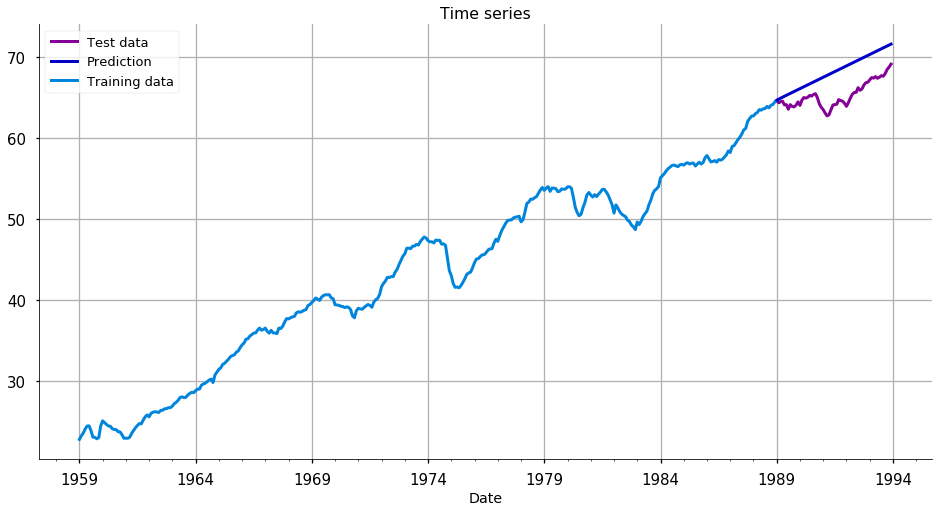

In [18]:
pred_gr(d_set, pred2)

### Построение ARIMA(1, 1, 2)

In [19]:
p = 1
q = 2

model3 = sma.ARIMA(d_set, order=(p, d, q)).fit()
print(model3.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                  359
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -120.312
Method:                       css-mle   S.D. of innovations              0.338
Date:                Sun, 10 Dec 2017   AIC                            250.624
Time:                        20:06:52   BIC                            270.040
Sample:                    02-01-1959   HQIC                           258.345
                         - 12-01-1988                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1177      0.036      3.229      0.001       0.046       0.189
ar.L1.D.Value     0.6823      0.124      5.499      0.000       0.439       0.926
ma.L1.D.Value    -0.3223      0.133     

In [20]:
d_set_test.head(n=3)

,Value
Date,
1989-01-01,64.6158
1989-02-01,64.3268
1989-03-01,64.4548


#### Построение предсказания

In [21]:
pred3 = model3.predict('1989-01-01', '1993-12-01', typ='levels')
pred3.head(n=3)

1989-01-01    64.607629
1989-02-01    64.767490
1989-03-01    64.913959
Freq: MS, dtype: float64

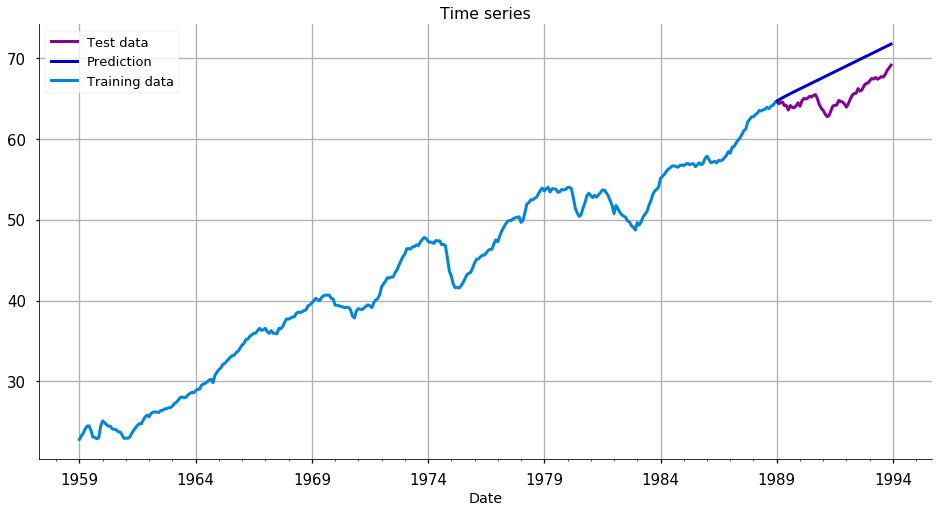

In [22]:
pred_gr(d_set, pred3)

### Построение ARIMA(0, 1, 4)

In [23]:
p = 0
q = 4

model4 = sma.ARIMA(d_set, order=(p, d, q)).fit()
print(model4.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                  359
Model:                 ARIMA(0, 1, 4)   Log Likelihood                -116.503
Method:                       css-mle   S.D. of innovations              0.335
Date:                Sun, 10 Dec 2017   AIC                            245.005
Time:                        20:06:58   BIC                            268.305
Sample:                    02-01-1959   HQIC                           254.271
                         - 12-01-1988                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1172      0.035      3.326      0.001       0.048       0.186
ma.L1.D.Value     0.3703      0.052      7.132      0.000       0.269       0.472
ma.L2.D.Value     0.2371      0.055     

In [24]:
d_set_test.head(n=3)

,Value
Date,
1989-01-01,64.6158
1989-02-01,64.3268
1989-03-01,64.4548


In [25]:
pred4 = model4.predict('1989-01-01', '1993-12-01', typ='levels')
pred4.head(n=3)

1989-01-01    64.588148
1989-02-01    64.784289
1989-03-01    64.925059
Freq: MS, dtype: float64

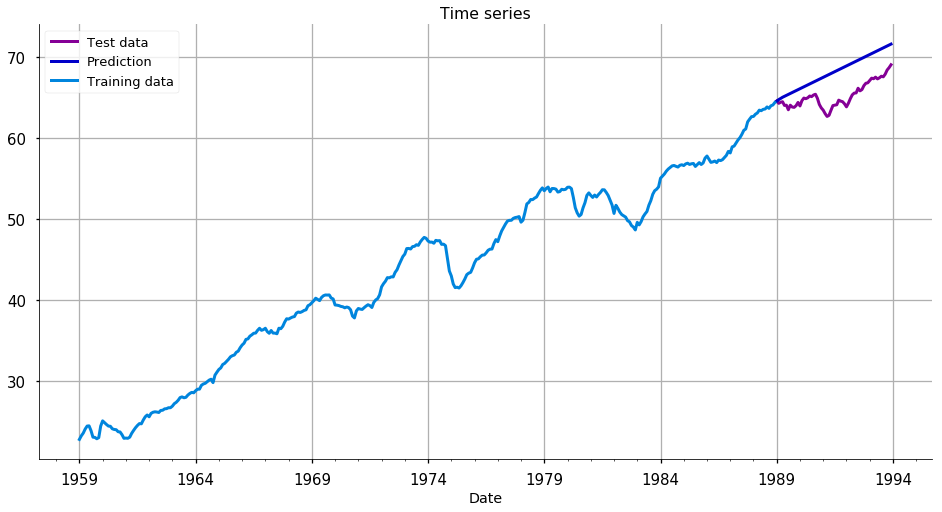

In [26]:
pred_gr(d_set, pred4)

### Сравнение предсказаний моделей

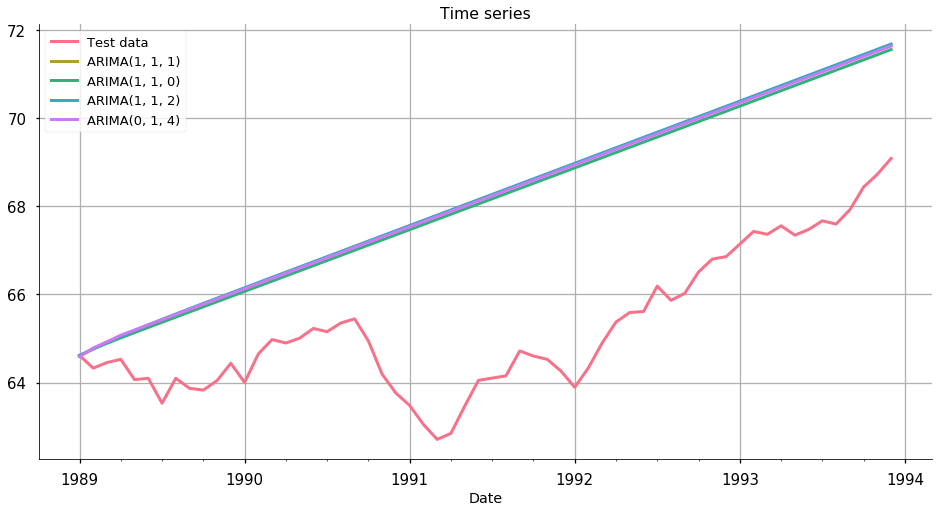

In [40]:
fig = d_set_test.plot(figsize=(16, 8), title='Time series', fontsize=15)
sb.set_palette("nipy_spectral", 12)
pred1.plot(ax=fig)
pred2.plot(ax=fig)
pred3.plot(ax=fig)
pred4.plot(ax=fig)
fig.legend(['Test data', 'ARIMA(1, 1, 1)',
            'ARIMA(1, 1, 0)', 'ARIMA(1, 1, 2)',
            'ARIMA(0, 1, 4)'])
fig.grid()
sb.despine()


### Коэффициент детерминации R^2

In [28]:
r2 = r2_score(d_set_test, pred1)
print('R^2 = %1.2f' % r2)

r2 = r2_score(d_set_test, pred2)
print('R^2 = %1.2f' % r2)

r2 = r2_score(d_set_test, pred3)
print('R^2 = %1.2f' % r2)

r2 = r2_score(d_set_test, pred4)
print('R^2 = %1.2f' % r2)

R^2 = -3.28
R^2 = -3.06
R^2 = -3.31
R^2 = -3.23


### Критерий AIC

In [29]:
print('AIC ARIMA(1, 1, 1): %1.2f' % model1.aic)
print('AIC ARIMA(1, 1, 0): %1.2f' % model2.aic)
print('AIC ARIMA(1, 1, 2): %1.2f' % model3.aic)
print('AIC ARIMA(0, 1, 4): %1.2f - min' % model4.aic)

AIC ARIMA(1, 1, 1): 248.73
AIC ARIMA(1, 1, 0): 251.98
AIC ARIMA(1, 1, 2): 250.62
AIC ARIMA(0, 1, 4): 245.01 - min


### Порядок сезонного интегрирования

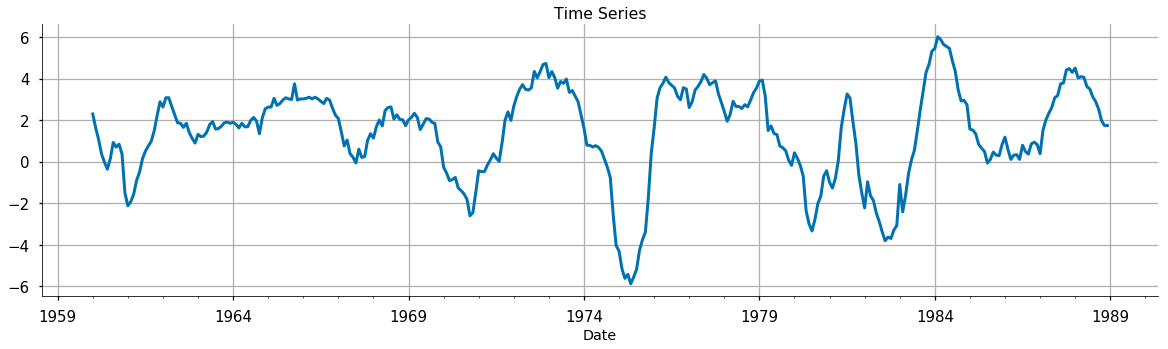

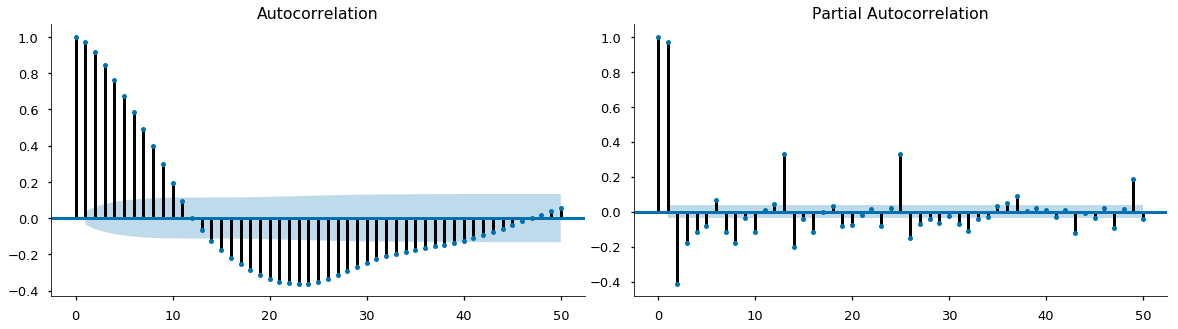

In [30]:
d_set_sdiff = sme.tools.diff(d_set['Value'], k_diff=0,
                             k_seasonal_diff=1,
                             seasonal_periods=12)
check_stationarity_DF(d_set_sdiff)
graphs(d_set_sdiff)

### Построение SARIMAX (10, 1, 5, 12)

In [31]:
model5 = sme.sarimax.SARIMAX(d_set, order=(0, 0, 0),
                             seasonal_order=((1, 0, 0, 0, 0, 1, 1, 1, 0, 1),
                                             1, (0, 0, 1, 0, 1), 12))
res = model5.fit()
pred5 = res.predict(start='1959-12-01', end='1993-12-01')
res.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                             Statespace Model Results                            
=================================================================================
Dep. Variable:                     Value   No. Observations:                  360
Model:             SARIMAX(10, 1, 5, 12)   Log Likelihood                -774.615
Date:                   Sun, 10 Dec 2017   AIC                           1565.229
Time:                           20:09:29   BIC                           1596.318
Sample:                       01-01-1959   HQIC                          1577.591
                            - 12-01-1988                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.0981      0.062      1.570      0.116      -0.024       0.221
ar.S.L72      -0.0396      0.076     -0.523      0.601      -0.188       0.109
ar.S.L84       0.2677      0.063      4.259      0.000       0.145       0.391
ar.S.L96       0.3127      0.066      4.766      0.000       0.184       0.441
ar.S.L120      0.2054      0.071      2.887      0.004       0.066       0.345
ma.S.L36      -0.2678      0.103     -2.613      0.009      -0.469      -0.067
ma.S.L60       0.3124      0.073      4.272      0.000       0.169       0.456
sigma2         4.4318      0.384     11.543      0.000       3.679       5.184
===================================================================================
Ljung-Box (Q):                     1792.48   Jarque-Bera (JB):                12.60
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.61   Skew:                            -0.45
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

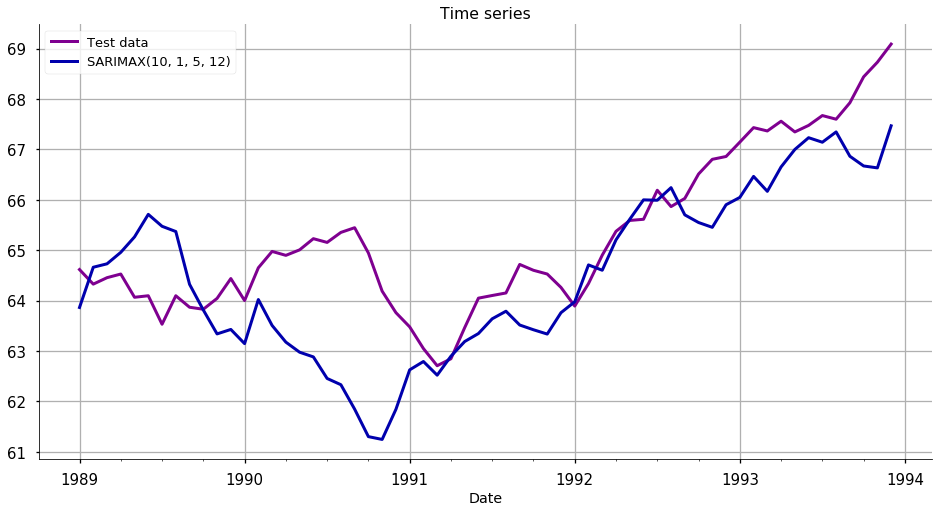

In [41]:
fig = d_set_test.plot(figsize=(16, 8), title='Time series', fontsize=15)
sb.set_palette("nipy_spectral", 12)
pred5['1989-01-01':].plot(ax=fig)
fig.legend(['Test data', 'SARIMAX(10, 1, 5, 12)'])
fig.grid()
sb.despine()

### Построение SARIMAX (7, 1, 4, 12)

In [35]:
model6 = sme.sarimax.SARIMAX(d_set, order=(0, 0, 0),
                             seasonal_order=((1, 0, 0, 0, 0, 1, 0),
                                             1, (0, 0, 0, 1), 12))
res = model6.fit()
pred6 = res.predict(start='1959-01-01', end='1993-12-01')
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            Statespace Model Results                            
================================================================================
Dep. Variable:                    Value   No. Observations:                  360
Model:             SARIMAX(7, 1, 4, 12)   Log Likelihood                -810.293
Date:                  Sun, 10 Dec 2017   AIC                           1628.585
Time:                          20:11:22   BIC                           1644.129
Sample:                      01-01-1959   HQIC                          1634.766
                           - 12-01-1988                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.2004      0.061      3.289      0.001       0.081       0.320
ar.S.L72       0.0928      0.064      1.441      0.150      -0.033       0.219
ma.S.L48       0.1533      0.053      2.869      0.004       0.049       0.258
sigma2         6.1251      0.585     10.469      0.000       4.978       7.272
===================================================================================
Ljung-Box (Q):                     1837.65   Jarque-Bera (JB):                34.93
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.77   Skew:                            -0.70
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

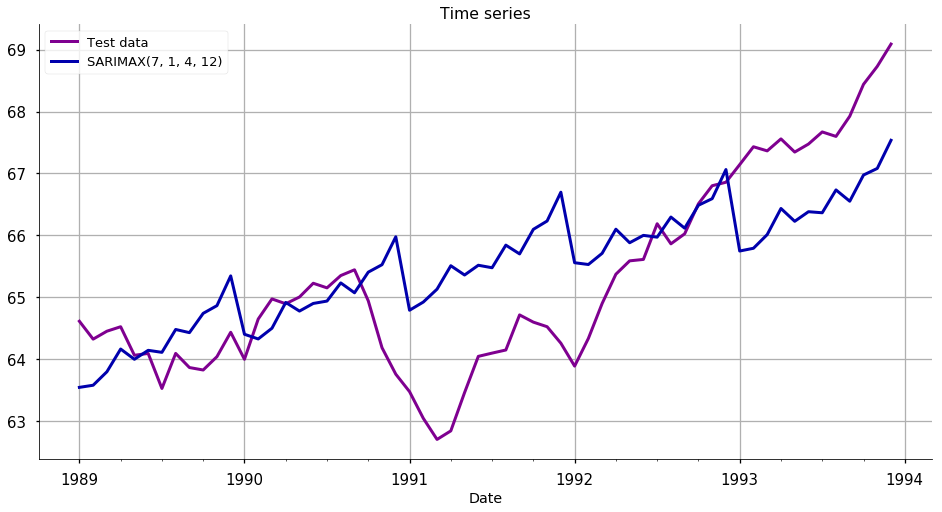

In [42]:
fig = d_set_test.plot(figsize=(16, 8), title='Time series', fontsize=15)
sb.set_palette("nipy_spectral", 12)
pred6['1989-01-01':].plot(ax=fig)
fig.legend(['Test data', 'SARIMAX(7, 1, 4, 12)'])
fig.grid()
sb.despine()

### Построение SARIMAX (8, 1, 0, 12)

In [37]:
model7 = sme.sarimax.SARIMAX(d_set, order=(0, 0, 0),
                             seasonal_order=((1, 1, 1, 0, 0, 1, 0, 1),
                                             1, 0, 12))
res = model7.fit()
pred7 = res.predict(start='1959-01-01', end='1993-12-01')
res.summary()

# (8,0,9)(3,1,2,12) по ACF/PACF

<class 'statsmodels.iolib.summary.Summary'>
"""
                            Statespace Model Results                            
================================================================================
Dep. Variable:                    Value   No. Observations:                  360
Model:             SARIMAX(8, 1, 0, 12)   Log Likelihood                -805.120
Date:                  Sun, 10 Dec 2017   AIC                           1622.241
Time:                          20:12:07   BIC                           1645.558
Sample:                      01-01-1959   HQIC                          1631.512
                           - 12-01-1988                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.2256      0.059      3.797      0.000       0.109       0.342
ar.S.L24      -0.1525      0.059     -2.573      0.010      -0.269      -0.036
ar.S.L36       0.1151      0.068      1.693      0.091      -0.018       0.248
ar.S.L72       0.1341      0.055      2.433      0.015       0.026       0.242
ar.S.L96       0.1747      0.075      2.332      0.020       0.028       0.321
sigma2         5.8883      0.613      9.607      0.000       4.687       7.090
===================================================================================
Ljung-Box (Q):                     1737.70   Jarque-Bera (JB):                39.21
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.52   Skew:                            -0.77
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

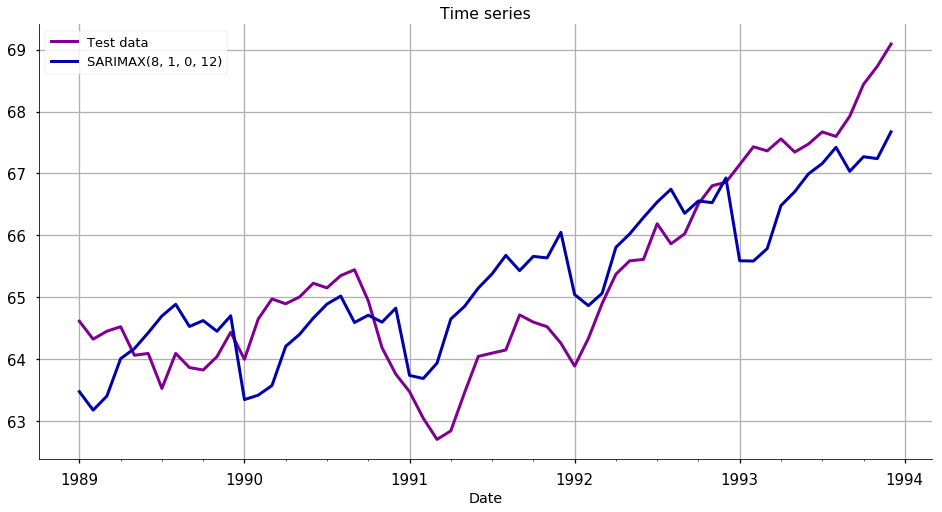

In [43]:
fig = d_set_test.plot(figsize=(16, 8), title='Time series', fontsize=15)
sb.set_palette("nipy_spectral", 12)
pred7['1989-01-01':].plot(ax=fig)
fig.legend(['Test data', 'SARIMAX(8, 1, 0, 12)'])
fig.grid()
sb.despine()

### Сравнение моделей SARIMAX

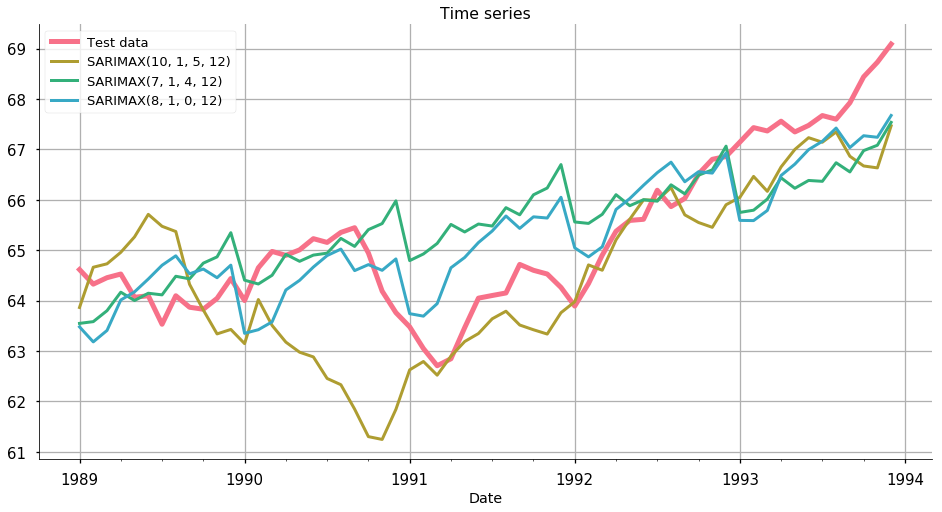

In [46]:
sb.set_context("talk", rc={"lines.linewidth": 3})
sb.set_palette("husl", 5)

fig = d_set_test.plot(figsize=(16, 8), title='Time series',
                      fontsize=15, linewidth=5)
pred5['1989-01-01':].plot(ax=fig)
pred6['1989-01-01':].plot(ax=fig)
pred7['1989-01-01':].plot(ax=fig)

fig.legend(['Test data', 'SARIMAX(10, 1, 5, 12)',
            'SARIMAX(7, 1, 4, 12)', 'SARIMAX(8, 1, 0, 12)'])
fig.grid()
sb.despine()